In [5]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

# First step will be to import the feature data and the labels
data_path = "/home/yacine/Documents/aec_vs_wpli/full_wei_data.csv";
data = pd.read_csv(data_path)
# here what everything means:
'''
frequencies = {"alpha","beta","delta","theta","gamma"};
epochs = {'ec1','emf5','ec1','if5','emf5','eml5','ec3','ec8'};
graph = {"aec","pli"}
The ids we see are mapping to these
'''
data

p_id  frequency  epoch  graph  window    mean_1    mean_2    mean_3  \
0        1          1      1      0       1  0.214410  0.206480  0.186960   
1        1          1      1      1       1  0.135180  0.133150  0.066425   
2        1          1      1      0       2  0.173520  0.176050  0.207510   
3        1          1      1      1       2  0.135480  0.110920  0.099013   
4        1          1      1      0       3  0.090807  0.194400  0.160160   
...    ...        ...    ...    ...     ...       ...       ...       ...   
5121     9          1      5      1      57  0.085781  0.116110  0.072873   
5122     9          1      5      0      58  0.307900  0.264840  0.296560   
5123     9          1      5      1      58  0.085440  0.129950  0.050824   
5124     9          1      5      0      59  0.344910  0.281380  0.377400   
5125     9          1      5      1      59  0.093926  0.046307  0.063297   

        mean_4    mean_5  ...  clust_coeff_ 77  clust_coeff_ 78  \
0     0.095920  0.185300  ...         0.111200         0.127020   
1     0.142670  0.187410  ...         0.106720         0.128150   
2     0.196660  0.100010  ...         0.193260         0.181300   
3     0.136760  0.166900  ...         0.091389         0.103490   
4     0.122470  0.049862  ...         0.115170         0.109680   
...        ...       ...  ...              ...              ...   
5121  0.079452  0.080033  ...         0.086054         0.083167   
5122  0.317740  0.280580  ...         0.272300         0.276280   
5123  0.047407  0.078008  ...         0.060591         0.067202   
5124  0.359230  0.308220  ...         0.361720         0.350360   
5125  0.090314  0.112560  ...         0.078507         0.085154   

      clust_coeff_ 79  clust_coeff_ 80  clust_coeff_ 81  clust_coeff_ 82  \
0            0.102430         0.137680         0.151390         0.101670   
1            0.104750         0.105940         0.094395         0.109470   
2            0.098848         0.171360         0.131640         0.119280   
3            0.113290         0.102150         0.087017         0.120590   
4            0.092119         0.157790         0.145170         0.150840   
...               ...              ...              ...              ...   
5121         0.086282         0.072647         0.075959         0.085231   
5122         0.280340         0.253770         0.313150         0.281930   
5123         0.073335         0.072248         0.078970         0.078899   
5124         0.297770         0.241940         0.358410         0.273790   
5125         0.099607         0.100100         0.082558         0.086202   

      norm_avg_clust_coeff  norm_g_eff  community  small_worldness  
0                  0.99897     0.97336   0.147250          0.95888  
1                  0.99442     0.97609   0.117070          0.95943  
2                  0.99763     0.98745   0.083997          0.97921  
3                  0.99338     0.98542   0.119380          0.96962  
4                  0.99841     0.98561   0.147540          0.97606  
...                    ...         ...        ...              ...  
5121               0.99393     0.99175   0.126100          0.97678  
5122               0.99971     0.97754   0.048422          0.96084  
5123               0.99197     0.99530   0.116520          0.98326  
5124               1.00010     0.96840   0.065216          0.94829  
5125               0.99093     0.99619   0.126130          0.98270  

[5126 rows x 255 columns]

In [5]:
# We will keep the same structure than we did in the AEC vs wPLI project for the machine learning

# Machine Learning 
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
# Sklearn utils
from sklearn.base import clone
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

# aec = 0 pli = 1
analysis_type = 1
epochs_to_keep = [1,4]
analysis = data['graph'] == analysis_type
baseline = data['epoch'] == epochs_to_keep[0]
other = data['epoch'] == epochs_to_keep[1]
subset_data = data[analysis & (baseline | other)]

clfs = [LinearDiscriminantAnalysis(solver='svd'), SVC(kernel='linear', C=0.1),SVC(kernel='linear', C=0.5), SVC(kernel='linear', C=1.0), SVC(kernel='rbf', C=0.1), SVC(kernel='rbf',C=1.0),RandomForestClassifier(n_estimators=100, max_depth=2,random_state=0)]
selected_clf = clfs[2]

def classify(dataset, original_clf):
    clf = clone(original_clf)
    # Initialize the Result data structures
    cms = []
    accuracies = []
    reports = []
    for test_id in range(1,10):
        #print("Participant: " + str(test_id) + " in hold-out set:")
        
        # Split the data in a leave one subject out manner
        
        # Get the training and test dataset
        training_dataset = dataset[dataset['p_id'] != test_id]
        test_dataset = dataset[dataset['p_id'] == test_id]
        
        # Get the X and Y 
        X_train = training_dataset.iloc[:,5:]
        y_train = training_dataset['epoch']
        
        # Training the min max normalizer
        min_max_scaler = MinMaxScaler()
        min_max_scaler.fit(X_train)
        X_train = min_max_scaler.transform(X_train)
        
        X_test = test_dataset.iloc[:,5:]
        y_test = test_dataset['epoch']
        
        # Normalize the test set using a training scaler
        X_test = min_max_scaler.transform(X_test)
        
        # Fitting our model
        clf.fit(X_train, y_train)

        # predicting
        y_pred = clf.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)

        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy = accuracy_score(y_test, y_pred)
        print("Generalization accuracy: " + str(accuracy))
        #print(cm)
        #print(report)
        
        # Saving the results
        cms.append(cm)
        accuracies.append(accuracy)
        reports.append(report)
        
    return (cms,accuracies,reports)

(cms, accuracies, report) = classify(subset_data, selected_clf)
print("Mean accuracy is: " + str(np.mean(accuracies)))

Participant: 1 in hold-out set:
Generalization accuracy: 0.7391304347826086
Participant: 2 in hold-out set:
Generalization accuracy: 0.9565217391304348
Participant: 3 in hold-out set:
Generalization accuracy: 0.6260869565217392
Participant: 4 in hold-out set:
Generalization accuracy: 0.9557522123893806
Participant: 5 in hold-out set:
Generalization accuracy: 0.6896551724137931
Participant: 6 in hold-out set:
Generalization accuracy: 0.9900990099009901
Participant: 7 in hold-out set:
Generalization accuracy: 0.9310344827586207
Participant: 8 in hold-out set:
Generalization accuracy: 0.6448598130841121
Participant: 9 in hold-out set:
Generalization accuracy: 0.9568965517241379
Mean accuracy is: 0.8322262636339797


In [111]:
# Iterating through all the epoch and aggregating all the averages
selected_clf = clfs[2] # goes from 0 to 7
total = 0
for a_i in range(0,2):
    for e_i in range(2,6):
        analysis_type = a_i # 0 = aec, 1 = wPLI
        epochs_to_keep = [1,e_i]
        analysis = data['graph'] == analysis_type
        baseline = data['epoch'] == epochs_to_keep[0]
        other = data['epoch'] == epochs_to_keep[1]
        subset_data = data[analysis & (baseline | other)]
        (cms, accuracies, report) = classify(subset_data, selected_clf)
        total = total + np.mean(accuracies)
print("Average performance for classifier = " + str(total/8))

Participant: 1 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 2 in hold-out set:
Participant: 3 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 4 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 5 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 6 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 7 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 8 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 9 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 1 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 2 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 3 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 4 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 5 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 6 in hold-out set:
Participant: 7 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 8 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 9 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 1 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 2 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 3 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 4 in hold-out set:
Participant: 5 in hold-out set:

C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 6 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 7 in hold-out set:
Participant: 8 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 9 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 1 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 2 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Participant: 3 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 4 in hold-out set:
Participant: 5 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 6 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 7 in hold-out set:
Participant: 8 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 9 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Participant: 1 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 2 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 3 in hold-out set:
Participant: 4 in hold-out set:
Participant: 5 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 6 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 7 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 8 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 9 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 1 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 2 in hold-out set:
Participant: 3 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 4 in hold-out set:
Participant: 5 in hold-out set:

C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



Participant: 6 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 7 in hold-out set:
Participant: 8 in hold-out set:

C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



Participant: 9 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 1 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 2 in hold-out set:
Participant: 3 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 4 in hold-out set:
Participant: 5 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 6 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 7 in hold-out set:
Participant: 8 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 9 in hold-out set:
Participant: 1 in hold-out set:

C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)



Participant: 2 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 3 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 4 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 5 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 6 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 7 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Participant: 8 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Participant: 9 in hold-out set:


C:\Users\biapt\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Average performance for classifier = 0.5488475819266965


## Average Classification Result
- LDA : 0.6650799789491493
- Linear SVM C=0.1 : 0.6850622618599771
- Linear SVM C=0.5 : 0.6852205308138111
- Linear SVM C=1.0 : 0.6842265725506583
- RBF SVM C=0.1 : 0.5581517916164056
- RBF SVM C=1.0 : 0.6448795803208284
- RF n=100, max=2 : 0.6528903224361835

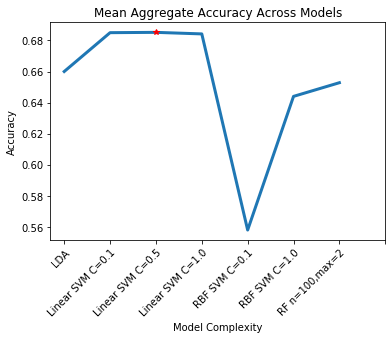

In [12]:
# Generating the figure 
# Visualization
import matplotlib.pyplot as plt
#Helper function
def make_plot(data,title):
    #static data
    models = ["LDA","Linear SVM C=0.1", "Linear SVM C=0.5", "Linear SVM C=1.0", "RBF SVM C=0.1", "RBF SVM C=1.0", "RF n=100,max=2"]
    x = [0,1,2,3,4,5,6]

    # Figure 
    fig = plt.figure()
    ax = plt.axes()

    ax.plot(x, data, linewidth=3)
    ax.plot(2,data[2],'r*')

    ax.set(xticks=np.arange(len(data) + 1),
        # ... and label them with the respective list entries
        xticklabels=models,
        title=title,
        ylabel='Accuracy',
        xlabel='Model Complexity')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
        rotation_mode="anchor")

    plt.show()
    
aggregate = [0.66, 0.6850, 0.6852, 0.6842, 0.558, 0.644 ,0.6528]
make_plot(aggregate, "Mean Aggregate Accuracy Across Models")

In [8]:
from math import floor
import pickle
import copy
from sklearn.utils import resample

# Now we need to add in the bootstrap confidence interval and the permutation testing
# Iterate num_bootstrap times and create a classifier with the resampled data
# Then create confidence interval for the and the accuracy, f_1 score
# The p value used here is 0.05
# This means that the lower bound = math.floor((num_bootstrap/100)*2.5)
#                     upper bound = math.floor((num_bootstrap/100)*97.5)
def generate_confidence_interval(original_dataset, clf, num_bootstrap):
    lb_index = floor((num_bootstrap/100)*(2.5))
    ub_index = floor((num_bootstrap/100)*(97.5))

    accuracies = []

    conf_interval_accuracy = (-1,-1)

    # Here we overwrite the dataset X, y and I and run the classify function
    # for each bootstrap samples
    for b_id in range(num_bootstrap):
        print("Bootstrap sample #" + str(b_id))
        # Copy the original dataset before manipulating it
        dataset = copy.deepcopy(original_dataset)

        # Get the sampled with replacement dataset
        resampled_data = resample(dataset)

        # Classify and get the results
        (cms, acc, report) = classify(resampled_data, clf)

        accuracies.append(np.mean(acc))
                          
    # Sort the results
    accuracies.sort()

    # Set the confidence interval at the right index
    conf_interval_accuracy = (accuracies[lb_index],accuracies[ub_index])

    return (accuracies,conf_interval_accuracy)

# Bootstrap experiment setup
filename = "wpli_pre_roc"
selected_clf = clfs[2] # 2 was the best
analysis_type = 1 # 0 = aec, 1 = wPLI
epochs_to_keep = [1,4]
analysis = data['graph'] == analysis_type
baseline = data['epoch'] == epochs_to_keep[0]
other = data['epoch'] == epochs_to_keep[1]
subset_data = data[analysis & (baseline | other)]
                          
# Generate confidence interval for the classifier
num_bootstrap = 5000
(accuracies,conf_interval_accuracy) = generate_confidence_interval(subset_data, selected_clf, num_bootstrap)
print("Confidence interval for Accuracy: " + str(conf_interval_accuracy))
pickle_out = open(filename,"wb")
pickle.dump(accuracies, pickle_out)
pickle_out.close()

Bootstrap sample #0
Bootstrap sample #1
Bootstrap sample #2
Bootstrap sample #3
Bootstrap sample #4
Bootstrap sample #5
Bootstrap sample #6
Bootstrap sample #7
Bootstrap sample #8
Bootstrap sample #9
Participant: 1 in hold-out set:
Participant: 2 in hold-out set:
Participant: 3 in hold-out set:
Participant: 4 in hold-out set:
Participant: 5 in hold-out set:
Participant: 6 in hold-out set:
Participant: 7 in hold-out set:
Participant: 8 in hold-out set:
Participant: 9 in hold-out set:
Confidence interval for Accuracy: (0.8537791111162774, 0.9098140292732381)


Bootstrap sample #378
Bootstrap sample #379
Bootstrap sample #380
Bootstrap sample #381
Bootstrap sample #382
Bootstrap sample #383
Bootstrap sample #384
Bootstrap sample #385
Bootstrap sample #386
Bootstrap sample #387
Bootstrap sample #388
Bootstrap sample #389
Bootstrap sample #390
Bootstrap sample #391
Bootstrap sample #392
Bootstrap sample #393
Bootstrap sample #394
Bootstrap sample #395
Bootstrap sample #396
Bootstrap sample #397
Bootstrap sample #398
Bootstrap sample #399
Bootstrap sample #400
Bootstrap sample #401
Bootstrap sample #402
Bootstrap sample #403
Bootstrap sample #404
Bootstrap sample #405
Bootstrap sample #406
Bootstrap sample #407
Bootstrap sample #408
Bootstrap sample #409
Bootstrap sample #410
Bootstrap sample #411
Bootstrap sample #412
Bootstrap sample #413
Bootstrap sample #414
Bootstrap sample #415
Bootstrap sample #416
Bootstrap sample #417
Bootstrap sample #418
Bootstrap sample #419
Bootstrap sample #420
Bootstrap sample #421
Bootstrap sample #422
Bootstrap 

Bootstrap sample #751
Bootstrap sample #752
Bootstrap sample #753
Bootstrap sample #754
Bootstrap sample #755
Bootstrap sample #756
Bootstrap sample #757
Bootstrap sample #758
Bootstrap sample #759
Bootstrap sample #760
Bootstrap sample #761
Bootstrap sample #762
Bootstrap sample #763
Bootstrap sample #764
Bootstrap sample #765
Bootstrap sample #766
Bootstrap sample #767
Bootstrap sample #768
Bootstrap sample #769
Bootstrap sample #770
Bootstrap sample #771
Bootstrap sample #772
Bootstrap sample #773
Bootstrap sample #774
Bootstrap sample #775
Bootstrap sample #776
Bootstrap sample #777
Bootstrap sample #778
Bootstrap sample #779
Bootstrap sample #780
Bootstrap sample #781
Bootstrap sample #782
Bootstrap sample #783
Bootstrap sample #784
Bootstrap sample #785
Bootstrap sample #786
Bootstrap sample #787
Bootstrap sample #788
Bootstrap sample #789
Bootstrap sample #790
Bootstrap sample #791
Bootstrap sample #792
Bootstrap sample #793
Bootstrap sample #794
Bootstrap sample #795
Bootstrap 

Bootstrap sample #1119
Bootstrap sample #1120
Bootstrap sample #1121
Bootstrap sample #1122
Bootstrap sample #1123
Bootstrap sample #1124
Bootstrap sample #1125
Bootstrap sample #1126
Bootstrap sample #1127
Bootstrap sample #1128
Bootstrap sample #1129
Bootstrap sample #1130
Bootstrap sample #1131
Bootstrap sample #1132
Bootstrap sample #1133
Bootstrap sample #1134
Bootstrap sample #1135
Bootstrap sample #1136
Bootstrap sample #1137
Bootstrap sample #1138
Bootstrap sample #1139
Bootstrap sample #1140
Bootstrap sample #1141
Bootstrap sample #1142
Bootstrap sample #1143
Bootstrap sample #1144
Bootstrap sample #1145
Bootstrap sample #1146
Bootstrap sample #1147
Bootstrap sample #1148
Bootstrap sample #1149
Bootstrap sample #1150
Bootstrap sample #1151
Bootstrap sample #1152
Bootstrap sample #1153
Bootstrap sample #1154
Bootstrap sample #1155
Bootstrap sample #1156
Bootstrap sample #1157
Bootstrap sample #1158
Bootstrap sample #1159
Bootstrap sample #1160
Bootstrap sample #1161
Bootstrap s

Bootstrap sample #1476
Bootstrap sample #1477
Bootstrap sample #1478
Bootstrap sample #1479
Bootstrap sample #1480
Bootstrap sample #1481
Bootstrap sample #1482
Bootstrap sample #1483
Bootstrap sample #1484
Bootstrap sample #1485
Bootstrap sample #1486
Bootstrap sample #1487
Bootstrap sample #1488
Bootstrap sample #1489
Bootstrap sample #1490
Bootstrap sample #1491
Bootstrap sample #1492
Bootstrap sample #1493
Bootstrap sample #1494
Bootstrap sample #1495
Bootstrap sample #1496
Bootstrap sample #1497
Bootstrap sample #1498
Bootstrap sample #1499
Bootstrap sample #1500
Bootstrap sample #1501
Bootstrap sample #1502
Bootstrap sample #1503
Bootstrap sample #1504
Bootstrap sample #1505
Bootstrap sample #1506
Bootstrap sample #1507
Bootstrap sample #1508
Bootstrap sample #1509
Bootstrap sample #1510
Bootstrap sample #1511
Bootstrap sample #1512
Bootstrap sample #1513
Bootstrap sample #1514
Bootstrap sample #1515
Bootstrap sample #1516
Bootstrap sample #1517
Bootstrap sample #1518
Bootstrap s

Bootstrap sample #1833
Bootstrap sample #1834
Bootstrap sample #1835
Bootstrap sample #1836
Bootstrap sample #1837
Bootstrap sample #1838
Bootstrap sample #1839
Bootstrap sample #1840
Bootstrap sample #1841
Bootstrap sample #1842
Bootstrap sample #1843
Bootstrap sample #1844
Bootstrap sample #1845
Bootstrap sample #1846
Bootstrap sample #1847
Bootstrap sample #1848
Bootstrap sample #1849
Bootstrap sample #1850
Bootstrap sample #1851
Bootstrap sample #1852
Bootstrap sample #1853
Bootstrap sample #1854
Bootstrap sample #1855
Bootstrap sample #1856
Bootstrap sample #1857
Bootstrap sample #1858
Bootstrap sample #1859
Bootstrap sample #1860
Bootstrap sample #1861
Bootstrap sample #1862
Bootstrap sample #1863
Bootstrap sample #1864
Bootstrap sample #1865
Bootstrap sample #1866
Bootstrap sample #1867
Bootstrap sample #1868
Bootstrap sample #1869
Bootstrap sample #1870
Bootstrap sample #1871
Bootstrap sample #1872
Bootstrap sample #1873
Bootstrap sample #1874
Bootstrap sample #1875
Bootstrap s

Bootstrap sample #2190
Bootstrap sample #2191
Bootstrap sample #2192
Bootstrap sample #2193
Bootstrap sample #2194
Bootstrap sample #2195
Bootstrap sample #2196
Bootstrap sample #2197
Bootstrap sample #2198
Bootstrap sample #2199
Bootstrap sample #2200
Bootstrap sample #2201
Bootstrap sample #2202
Bootstrap sample #2203
Bootstrap sample #2204
Bootstrap sample #2205
Bootstrap sample #2206
Bootstrap sample #2207
Bootstrap sample #2208
Bootstrap sample #2209
Bootstrap sample #2210
Bootstrap sample #2211
Bootstrap sample #2212
Bootstrap sample #2213
Bootstrap sample #2214
Bootstrap sample #2215
Bootstrap sample #2216
Bootstrap sample #2217
Bootstrap sample #2218
Bootstrap sample #2219
Bootstrap sample #2220
Bootstrap sample #2221
Bootstrap sample #2222
Bootstrap sample #2223
Bootstrap sample #2224
Bootstrap sample #2225
Bootstrap sample #2226
Bootstrap sample #2227
Bootstrap sample #2228
Bootstrap sample #2229
Bootstrap sample #2230
Bootstrap sample #2231
Bootstrap sample #2232
Bootstrap s

Bootstrap sample #2547
Bootstrap sample #2548
Bootstrap sample #2549
Bootstrap sample #2550
Bootstrap sample #2551
Bootstrap sample #2552
Bootstrap sample #2553
Bootstrap sample #2554
Bootstrap sample #2555
Bootstrap sample #2556
Bootstrap sample #2557
Bootstrap sample #2558
Bootstrap sample #2559
Bootstrap sample #2560
Bootstrap sample #2561
Bootstrap sample #2562
Bootstrap sample #2563
Bootstrap sample #2564
Bootstrap sample #2565
Bootstrap sample #2566
Bootstrap sample #2567
Bootstrap sample #2568
Bootstrap sample #2569
Bootstrap sample #2570
Bootstrap sample #2571
Bootstrap sample #2572
Bootstrap sample #2573
Bootstrap sample #2574
Bootstrap sample #2575
Bootstrap sample #2576
Bootstrap sample #2577
Bootstrap sample #2578
Bootstrap sample #2579
Bootstrap sample #2580
Bootstrap sample #2581
Bootstrap sample #2582
Bootstrap sample #2583
Bootstrap sample #2584
Bootstrap sample #2585
Bootstrap sample #2586
Bootstrap sample #2587
Bootstrap sample #2588
Bootstrap sample #2589
Bootstrap s

Bootstrap sample #2904
Bootstrap sample #2905
Bootstrap sample #2906
Bootstrap sample #2907
Bootstrap sample #2908
Bootstrap sample #2909
Bootstrap sample #2910
Bootstrap sample #2911
Bootstrap sample #2912
Bootstrap sample #2913
Bootstrap sample #2914
Bootstrap sample #2915
Bootstrap sample #2916
Bootstrap sample #2917
Bootstrap sample #2918
Bootstrap sample #2919
Bootstrap sample #2920
Bootstrap sample #2921
Bootstrap sample #2922
Bootstrap sample #2923
Bootstrap sample #2924
Bootstrap sample #2925
Bootstrap sample #2926
Bootstrap sample #2927
Bootstrap sample #2928
Bootstrap sample #2929
Bootstrap sample #2930
Bootstrap sample #2931
Bootstrap sample #2932
Bootstrap sample #2933
Bootstrap sample #2934
Bootstrap sample #2935
Bootstrap sample #2936
Bootstrap sample #2937
Bootstrap sample #2938
Bootstrap sample #2939
Bootstrap sample #2940
Bootstrap sample #2941
Bootstrap sample #2942
Bootstrap sample #2943
Bootstrap sample #2944
Bootstrap sample #2945
Bootstrap sample #2946
Bootstrap s

Bootstrap sample #3261
Bootstrap sample #3262
Bootstrap sample #3263
Bootstrap sample #3264
Bootstrap sample #3265
Bootstrap sample #3266
Bootstrap sample #3267
Bootstrap sample #3268
Bootstrap sample #3269
Bootstrap sample #3270
Bootstrap sample #3271
Bootstrap sample #3272
Bootstrap sample #3273
Bootstrap sample #3274
Bootstrap sample #3275
Bootstrap sample #3276
Bootstrap sample #3277
Bootstrap sample #3278
Bootstrap sample #3279
Bootstrap sample #3280
Bootstrap sample #3281
Bootstrap sample #3282
Bootstrap sample #3283
Bootstrap sample #3284
Bootstrap sample #3285
Bootstrap sample #3286
Bootstrap sample #3287
Bootstrap sample #3288
Bootstrap sample #3289
Bootstrap sample #3290
Bootstrap sample #3291
Bootstrap sample #3292
Bootstrap sample #3293
Bootstrap sample #3294
Bootstrap sample #3295
Bootstrap sample #3296
Bootstrap sample #3297
Bootstrap sample #3298
Bootstrap sample #3299
Bootstrap sample #3300
Bootstrap sample #3301
Bootstrap sample #3302
Bootstrap sample #3303
Bootstrap s

Bootstrap sample #3618
Bootstrap sample #3619
Bootstrap sample #3620
Bootstrap sample #3621
Bootstrap sample #3622
Bootstrap sample #3623
Bootstrap sample #3624
Bootstrap sample #3625
Bootstrap sample #3626
Bootstrap sample #3627
Bootstrap sample #3628
Bootstrap sample #3629
Bootstrap sample #3630
Bootstrap sample #3631
Bootstrap sample #3632
Bootstrap sample #3633
Bootstrap sample #3634
Bootstrap sample #3635
Bootstrap sample #3636
Bootstrap sample #3637
Bootstrap sample #3638
Bootstrap sample #3639
Bootstrap sample #3640
Bootstrap sample #3641
Bootstrap sample #3642
Bootstrap sample #3643
Bootstrap sample #3644
Bootstrap sample #3645
Bootstrap sample #3646
Bootstrap sample #3647
Bootstrap sample #3648
Bootstrap sample #3649
Bootstrap sample #3650
Bootstrap sample #3651
Bootstrap sample #3652
Bootstrap sample #3653
Bootstrap sample #3654
Bootstrap sample #3655
Bootstrap sample #3656
Bootstrap sample #3657
Bootstrap sample #3658
Bootstrap sample #3659
Bootstrap sample #3660
Bootstrap s

Bootstrap sample #3975
Bootstrap sample #3976
Bootstrap sample #3977
Bootstrap sample #3978
Bootstrap sample #3979
Bootstrap sample #3980
Bootstrap sample #3981
Bootstrap sample #3982
Bootstrap sample #3983
Bootstrap sample #3984
Bootstrap sample #3985
Bootstrap sample #3986
Bootstrap sample #3987
Bootstrap sample #3988
Bootstrap sample #3989
Bootstrap sample #3990
Bootstrap sample #3991
Bootstrap sample #3992
Bootstrap sample #3993
Bootstrap sample #3994
Bootstrap sample #3995
Bootstrap sample #3996
Bootstrap sample #3997
Bootstrap sample #3998
Bootstrap sample #3999
Bootstrap sample #4000
Bootstrap sample #4001
Bootstrap sample #4002
Bootstrap sample #4003
Bootstrap sample #4004
Bootstrap sample #4005
Bootstrap sample #4006
Bootstrap sample #4007
Bootstrap sample #4008
Bootstrap sample #4009
Bootstrap sample #4010
Bootstrap sample #4011
Bootstrap sample #4012
Bootstrap sample #4013
Bootstrap sample #4014
Bootstrap sample #4015
Bootstrap sample #4016
Bootstrap sample #4017
Bootstrap s

Bootstrap sample #4332
Bootstrap sample #4333
Bootstrap sample #4334
Bootstrap sample #4335
Bootstrap sample #4336
Bootstrap sample #4337
Bootstrap sample #4338
Bootstrap sample #4339
Bootstrap sample #4340
Bootstrap sample #4341
Bootstrap sample #4342
Bootstrap sample #4343
Bootstrap sample #4344
Bootstrap sample #4345
Bootstrap sample #4346
Bootstrap sample #4347
Bootstrap sample #4348
Bootstrap sample #4349
Bootstrap sample #4350
Bootstrap sample #4351
Bootstrap sample #4352
Bootstrap sample #4353
Bootstrap sample #4354
Bootstrap sample #4355
Bootstrap sample #4356
Bootstrap sample #4357
Bootstrap sample #4358
Bootstrap sample #4359
Bootstrap sample #4360
Bootstrap sample #4361
Bootstrap sample #4362
Bootstrap sample #4363
Bootstrap sample #4364
Bootstrap sample #4365
Bootstrap sample #4366
Bootstrap sample #4367
Bootstrap sample #4368
Bootstrap sample #4369
Bootstrap sample #4370
Bootstrap sample #4371
Bootstrap sample #4372
Bootstrap sample #4373
Bootstrap sample #4374
Bootstrap s

Bootstrap sample #4689
Bootstrap sample #4690
Bootstrap sample #4691
Bootstrap sample #4692
Bootstrap sample #4693
Bootstrap sample #4694
Bootstrap sample #4695
Bootstrap sample #4696
Bootstrap sample #4697
Bootstrap sample #4698
Bootstrap sample #4699
Bootstrap sample #4700
Bootstrap sample #4701
Bootstrap sample #4702
Bootstrap sample #4703
Bootstrap sample #4704
Bootstrap sample #4705
Bootstrap sample #4706
Bootstrap sample #4707
Bootstrap sample #4708
Bootstrap sample #4709
Bootstrap sample #4710
Bootstrap sample #4711
Bootstrap sample #4712
Bootstrap sample #4713
Bootstrap sample #4714
Bootstrap sample #4715
Bootstrap sample #4716
Bootstrap sample #4717
Bootstrap sample #4718
Bootstrap sample #4719
Bootstrap sample #4720
Bootstrap sample #4721
Bootstrap sample #4722
Bootstrap sample #4723
Bootstrap sample #4724
Bootstrap sample #4725
Bootstrap sample #4726
Bootstrap sample #4727
Bootstrap sample #4728
Bootstrap sample #4729
Bootstrap sample #4730
Bootstrap sample #4731
Bootstrap s

In [102]:
# Getting the weights for the classification (the last one are important not the first one)
# Fucntion to get the weights out of the SVM
def get_weight(dataset, original_clf):
    clf = clone(original_clf)
    # Fitting our model
    X_train = dataset.iloc[:,5:]
    y_train = dataset['epoch']

    # Normalize the test set using a training scaler
    # Training the min max normalizer
    min_max_scaler = MinMaxScaler()
    min_max_scaler.fit(X_train)
    X_train = min_max_scaler.transform(X_train)
    X_train = min_max_scaler.transform(X_train)

    # Fitting our model
    clf.fit(X_train, y_train)

    # get weights
    weights = clf.coef_
    weights = np.abs(weights[0]) # Take the absolute values of the coefficients

    
    #norm_avg_clust_coeff 	norm_g_eff 	community 	small_worldness
    weights_mean = weights[0:82]
    weights_std = weights[82:164]
    weights_clust = weights[164:246]
    weight_avg_clust = weights[246]
    weight_g_eff = weights[247]
    weight_community = weights[248]
    weight_sm = weights[249]
    

    return weights_mean,weights_std,weights_clust,weight_avg_clust,weight_g_eff,weight_community,weight_sm

def find_rank_weight(target, weights):
    i = 0
    for weight in weights:
        if(target <= weight):
            return (i-1)/len(weights)
        i = i + 1
    return i/len(weights)
        
# Get the weights of the linear svm with c=0.5
selected_clf = clfs[2] # 2 was the best
analysis_type = 0 # 0 = aec, 1 = wPLI
epochs_to_keep = [1,3]
analysis = data['graph'] == analysis_type
baseline = data['epoch'] == epochs_to_keep[0]
other = data['epoch'] == epochs_to_keep[1]
subset_data = data[analysis & (baseline | other)]
weights_mean,weights_std,weights_clust,weight_avg_clust,weight_g_eff,weight_community,weight_sm = get_weight(subset_data, selected_clf)


# Try to find the relative importance of the graph feature in importance (%)
all_features = np.concatenate((weights_mean,weights_std),axis=0)
all_features = np.concatenate((all_features,weights_clust),axis=0)
np.append(all_features, [weight_avg_clust])
np.append(all_features, [weight_g_eff])
np.append(all_features, [weight_community])
np.append(all_features, [weight_sm])
all_features.sort()


# sum weights clust coeff
all_rank = 0
for i in range(0,len(weights_clust)):
    all_rank = all_rank + find_rank_weight(weights_clust[i], all_features)
all_rank = all_rank/len(weights_clust)
print("All cluster coefficient: " + str(all_rank))

# weight_avg_clust
rank_avg_clust = find_rank_weight(weight_avg_clust, all_features)
print("Avg Cluster Coefficient: " + str(rank_avg_single_clust))

# weight_g_eff
rank_g_eff = find_rank_weight(weight_g_eff, all_features)
print("Global Efficiency: " + str(rank_g_eff))

# weight_community
rank_community = find_rank_weight(weight_community, all_features)
print("Community: " + str(rank_community))

# weight_sm
rank_sm = find_rank_weight(weight_sm, all_features)
print("Smallworldness: " + str(rank_sm))

# All graph usefulness
usefulness = (rank_avg_clust + rank_g_eff + rank_community + rank_sm)/4
print("Graph usefulness: " + str(usefulness))

IndexError: index 246 is out of bounds for axis 0 with size 86

## Feature weights are hard to understand when not visualizing them
- I don't have time for this now, it would have been nice to have an already made functionality in python to put color on a brain (TODO)
- Will look at the stability of the classification with the graph (per participants)
    
    

In [138]:
# functional connectivity
fct_pli_unc = np.array([0.84,0.89,0.70,0.95,0.66,0.59,0.92,0.54,0.93])
fct_aec_unc = np.array([0.91,0.87,0.87,0.87,0.75,0.80,0.93,0.80,0.93])

fct_pli_prc = np.array([0.70,0.93,0.6,0.90,0.65,0.98,0.90,0.65,0.91])
fct_aec_prc = np.array([0.63,0.80,0.40,0.74,0.64,0.92,0.87,0.74,0.76])

# Graph Theory
gp_pli_unc = np.array([0.83,0.87,0.72,0.91,0.67,0.63,0.93,0.57,0.94])
gp_aec_unc = np.array([0.93,0.91,0.91,0.911,0.76,0.87,0.93,0.81,0.97])

gp_pli_prc = np.array([0.73,0.95,0.62,0.95,0.68,0.99,0.93,0.64,0.95])
gp_aec_prc = np.array([0.59,0.82,0.36,0.78,0.68,0.91,0.90,0.72,0.75])

# Check Mean and std
print("PLI Unconscious")
print("FC:" + str(np.mean(fct_pli_unc)) + str(np.std(fct_pli_unc)))
print("GP:" + str(np.mean(gp_pli_unc)) + str(np.std(gp_pli_unc)))
print("PLI pre-ROC")
print("FC:" + str(np.mean(fct_pli_prc)) + str(np.std(fct_pli_prc)))
print("GP:" + str(np.mean(gp_pli_prc)) + str(np.std(gp_pli_prc)))

print("AEC Unconscious")
print("FC:" + str(np.mean(fct_aec_unc)) + str(np.std(fct_aec_unc)))
print("GP:" + str(np.mean(gp_aec_unc)) + str(np.std(gp_aec_unc)))
print("AEC pre-ROC")
print("FC:" + str(np.mean(fct_aec_prc)) + str(np.std(fct_aec_prc)))
print("GP:" + str(np.mean(gp_aec_prc)) + str(np.std(gp_aec_prc)))

# Check Difference
diff_pli_unc = gp_pli_unc - fct_pli_unc
diff_pli_prc = gp_pli_prc - fct_pli_prc

diff_aec_unc = gp_aec_unc - fct_aec_unc
diff_aec_prc = gp_aec_prc - fct_aec_prc

print("PLI")
print(diff_pli_unc)
print(np.mean(diff_pli_unc))
print(diff_pli_prc)
print(np.mean(diff_pli_prc))
print("AEC")
print(diff_aec_unc)
print(np.mean(diff_aec_unc))
print(diff_aec_prc)
print(np.mean(diff_aec_prc))

PLI Unconscious
FC:0.77999999999999990.1495177432800387
GP:0.78555555555555560.13233888410785993
PLI pre-ROC
FC:0.80222222222222220.13998236220465443
GP:0.82666666666666670.1458309523615157
AEC Unconscious
FC:0.85888888888888890.059524867715461664
GP:0.88900000000000010.06194262578296862
AEC pre-ROC
FC:0.72222222222222220.1445896705837114
GP:0.72333333333333330.1602081978759722
PLI
[-0.01 -0.02  0.02 -0.04  0.01  0.04  0.01  0.03  0.01]
0.005555555555555548
[ 0.03  0.02  0.02  0.05  0.03  0.01  0.03 -0.01  0.04]
0.02444444444444443
AEC
[0.02  0.04  0.04  0.041 0.01  0.07  0.    0.01  0.04 ]
0.030111111111111113
[-0.04  0.02 -0.04  0.04  0.04 -0.01  0.03 -0.02 -0.01]
0.0011111111111110998


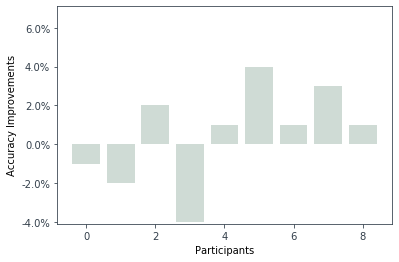

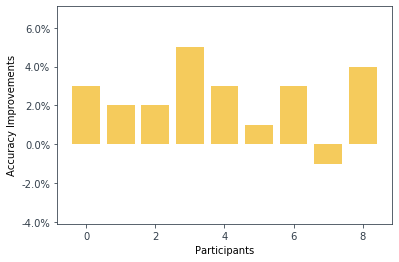

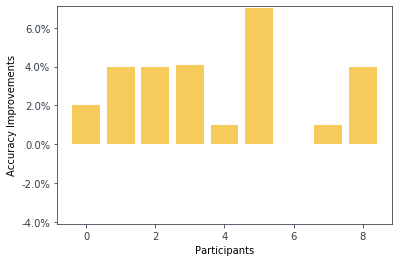

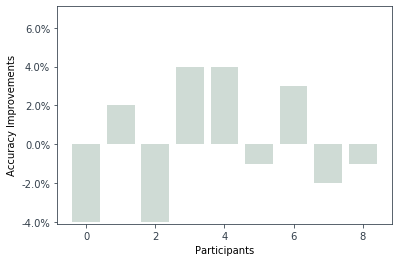

In [164]:
from matplotlib.ticker import FuncFormatter

# Make the plot (4 of them)
def percent(x, pos):
    'The two args are the value and tick position'
    return '%1.1f%s' % (x * 100,'%')


def barplot(data,minimum,maximum,color_t):
    x = np.arange(len(data))
    formatter = FuncFormatter(percent)
    fig, ax = plt.subplots()
    ax.yaxis.set_major_formatter(formatter)
    ax.set_xlabel('Participants')
    ax.set_ylabel('Accuracy Improvements')
    ax.set_ylim((minimum, maximum))
    plt.bar(x, data,color=color_t)
    
    plt.show()
    
    
# Setting up the styling
plt.rcParams['font.sans-serif'] = 'Helvetica'

plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'


#diff_pli_unc
#diff_pli_prc

#diff_aec_unc
#diff_aec_prc
min_y = -0.041
max_y = 0.071
orange = (255/255,127/255,14/255,1.0)
blue = (31/255,119/255,180/255,1.0)
grey = (207/255, 219/255, 213/255, 1.0)
accent = (245/255, 203/255, 92/255, 1.0)
barplot(diff_pli_unc,min_y,max_y,grey)
barplot(diff_pli_prc,min_y,max_y,accent)
barplot(diff_aec_unc,min_y,max_y,accent)
barplot(diff_aec_prc,min_y,max_y,grey)